## **Placing Semi-Landmarks**

In [1]:
# import logging
# mpl_logger = logging.getLogger('matplotlib')
# mpl_logger.setLevel(logging.WARNING) 

### General Imports
# import matplotlib.pyplot as plt
from glob import glob as glob
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import pyvista as pv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from IPython.display import Image

from chindef.systemsetup import systemsetup as systemsetup
# from chindef.systemsetup import systemsetup_kallisto as systemsetup
import chindef.utils.eval_utils as eutils
import chindef.utils.class_utils as cutils

info_file = systemsetup.INFO_FILE

data = 'cleaned_curve'

DATA_DIR = "{}/{}".format(systemsetup.DATA_DIR, data)
OUT_DIR = '{}/{}-semi_landmarks/Uniform'.format(systemsetup.DATA_DIR, data)

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

saveit = False

dim = 2

### **Info about specimen**

In [2]:
df = eutils.read_data(info_file, sheet='all_specimen')
specimen = list(df['specimen'])

df.head(5)

,ids,Group_ids,Group_names,specimen,age,age_in_days,sex,sexEnc,Group_ids_2,Group_names_2
0,1,0,European,embr_EMBR119,6y,2190.0,M,0.0,0,European_male
1,2,0,European,embr_EMBR121,5y,1825.0,F,1.0,1,European_female
2,3,0,European,embr_EMBR136,6y,2190.0,M,0.0,0,European_male
3,4,0,European,embr_EMBR180,10m,305.0,F,1.0,1,European_female
4,5,0,European,embr_EMBR201,3y7m,1309.0,M,0.0,0,European_male


#### **Functions to extract the semi-LMs on open curves**

In [3]:
from scipy.spatial import distance_matrix, distance

"""
    Sort the points in the curve
    - find starting point
    - get the shortest path sequence
    - reorder points accordingly
    """
def shortest_path(mesh):
    points = mesh.points

    # pairwise point distances
    mat_dist = distance.cdist(points, points, 'euclidean')
    df_mat_dist = pd.DataFrame(mat_dist)

    # find starting point 
    # first point is in lower left corner -> smallest x, smallest y -> smallest norm
    point_norms = np.linalg.norm(points, axis=1)
    closest_idx = np.argmin(point_norms)
    path_points = [closest_idx]

    # Shortest path + path length
    #Find the closest point to the starting point, different from diagonal and save results
    path_length = 0
    for _ in range(points.shape[0]-1):
        closest_dist = df_mat_dist.loc[closest_idx, ~df_mat_dist.index.isin(path_points)].min()
        closest_idx = df_mat_dist.loc[closest_idx, ~df_mat_dist.index.isin(path_points)].idxmin()
        path_points.append(closest_idx)
        path_length += closest_dist

    return points[path_points,:], path_length

"""
    Two ways to extract the semi-Landmarks
    'distance'  :   select LMs uniformly distributed over curve length
    'sampling'  :   select every Nth point
"""
def sample_curve(mesh, N, type='distance'):

    # points = mesh.points

    #
    # Reorder points so that they represent the shortest path from starting to end point of the curve
    points, length = shortest_path(mesh)
    print(f'Length of curve: {length}')
    Npoints = points.shape[0]

    if type == 'distance':

        # get uniform distance of N sampled points
        dist = length / (N-1)
        print(f'Distance of sampling poins: {dist}')

        # collect the starting and end point as first semi-Landmarks
        samples = np.zeros((N,3))
        samples[0,:] = points[0,:]
        samples[-1,:] = points[-1,:]

        # get samples over the distances
        ref = points[0,:]
        count = 0
        for i in range(2,Npoints-1):
            # distances of this and previous point
            d1 = distance.euclidean(ref, points[i-1,:])
            d2 = distance.euclidean(ref, points[i,:])
            
            # if the distance to this point is larger than the sampling distance 'dist',
            # -> we found a next semi-LM!
            if d2>dist:
                # check if this or the previous point is closer to desired distance 
                # 'dist' of the previously selected LM.
                s = np.argmin([abs(d1-dist), abs(d2-dist)])
                count += 1
                # if s==0:  ref = points[i-1,:]
                # else:     ref = points[i,:]
                ref = points[i+s-1,:]
                samples[count,:] = ref
    elif type=='sampling':

        # I can't ensure that the last point of the curve is part of the semi-LM set

        # just take every Nth sample
        samples = points[::N,:]

    return samples


In [14]:
# Plotting

def plot_landmarks(meshes, LMs, titles, pfile=None, show=False):

    M = len(meshes)

    fig = make_subplots(rows=1, cols=M, subplot_titles=titles)
    colors = ['red', 'coral', 'orange', 'yellow', 'green']

    for m in range(M):
        # Add traces
        # subplot m
        fig.add_trace(go.Scatter(x=meshes[m].points[:,0], y=meshes[m].points[:,1], mode='markers', 
                            marker=dict(color='blue', opacity=0.1, size=5),name='Original curve'), row=1, col=m+1)
        fig.add_trace(go.Scatter(x=LMs[m][:,0], y=LMs[m][:,1], 
                            mode='markers', marker=dict(color=colors[m]),name="Semi-LMs"),  row=1, col=m+1)

    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    fig.update_layout(height=400, width=M*500, title_text='',plot_bgcolor='rgba(255, 255, 255, 255)',paper_bgcolor='rgba(255, 255, 255, 255)')
    if pfile is not None:
        fig.write_image(pfile)
    if show:
        fig.show()

### **Examplary LM extraction on EMBR388**

In [15]:
mesh_file = f'{DATA_DIR}/embr_EMBR388.vtk'

mesh = pv.read(mesh_file)
points = np.asarray(mesh.points)

N = 20 # select N Semi-LMs
semiLMs = sample_curve(mesh, N, type='distance')
print(f'Number of semi-LMs (distance): {semiLMs.shape[0]}')

Nth = 30
semiLMs2 = sample_curve(mesh, Nth, type='sampling')
print(f'Number of semi-LMs (sampling): {semiLMs2.shape[0]}')


plot_landmarks([mesh, mesh], [semiLMs, semiLMs2], ("distance", "sampling"), pfile=None)



Length of curve: 38.02913802389635
Distance of sampling poins: 2.0015335802050713
Number of semi-LMs (distance): 20
Length of curve: 38.02913802389635
Number of semi-LMs (sampling): 20


#### **Extract semi-LMs**

method: 'distance'

In [17]:
Nr_SLM = 15 # 15, 20, 30

OUT_N_DIR = f'{OUT_DIR}/{Nr_SLM}'
if not os.path.exists(OUT_N_DIR):
    os.makedirs(OUT_N_DIR)

# directory for .png files to check the landmark placement
if not os.path.exists(OUT_N_DIR+'/check'):
    os.makedirs(OUT_N_DIR+'/check')

In [45]:
semi_landmarks = np.zeros((len(specimen),dim*Nr_SLM))

for si, spec in tqdm(enumerate(specimen)):

    # if si>0:
        # continue


    """
        Read original curve
    """
    curve = pv.read("{}/{}.vtk".format(DATA_DIR, spec))

    """
        Extract semi-LMs
    """
    semiLMs = sample_curve(curve, Nr_SLM, type='distance')
    # print(f'Number of semi-LMs (distance): {semiLMs.shape[0]}')

    """
        Save points
    """
    semiL = np.reshape(semiLMs[:,:2], (1,-1))
    semi_landmarks[si,:] = semiL

    """
        Visualization
    """
    plot_landmarks([curve], [semiLMs], (spec,), pfile=f'{OUT_N_DIR}/check/{spec}.png', show=False)
    
    


0it [00:00, ?it/s]

Length of curve: 35.11301902798732
Distance of sampling poins: 1.2107937595857696
Length of curve: 37.98306429212298
Distance of sampling poins: 1.3097608376594132
Length of curve: 37.20786889620855
Distance of sampling poins: 1.283029961938226
Length of curve: 38.33173404469823
Distance of sampling poins: 1.321783932575801
Length of curve: 37.67876766247297
Distance of sampling poins: 1.2992678504301025
Length of curve: 36.023466114526066
Distance of sampling poins: 1.2421884867077955
Length of curve: 37.983494789577016
Distance of sampling poins: 1.3097756823992075
Length of curve: 37.022606407757955
Distance of sampling poins: 1.2766416002675156
Length of curve: 33.714912216271586
Distance of sampling poins: 1.162583179871434
Length of curve: 37.46637082752051
Distance of sampling poins: 1.291943821638638
Length of curve: 36.34538679407001
Distance of sampling poins: 1.2532891997955176
Length of curve: 41.5688843892784
Distance of sampling poins: 1.4334098065268415
Length of curve: 

### **Save as spreadsheet**

In [46]:
data = {'specimen': specimen,
        'group_id': df['Group_ids'],
        'group_name': df['Group_names'],
        'age': df['age']}
dfsl = pd.DataFrame(data)

for idx in range(Nr_SLM):
    dfsl[f'semi-LM_{idx}_X'] = semi_landmarks[:,2*idx]
    dfsl[f'semi-LM_{idx}_Y'] = semi_landmarks[:,2*idx+1]

cutils.df_save_to_excel(f'{OUT_N_DIR}/profile_{Nr_SLM}_semilandmarks.xlsx', dfsl, 'semilandmarks')
dfsl.to_csv(f'{OUT_N_DIR}/profile_{Nr_SLM}_semilandmarks.csv')

dfsl

,specimen,group_id,group_name,age,semi-LM_0_X,semi-LM_0_Y,semi-LM_1_X,semi-LM_1_Y,semi-LM_2_X,semi-LM_2_Y,...,semi-LM_25_X,semi-LM_25_Y,semi-LM_26_X,semi-LM_26_Y,semi-LM_27_X,semi-LM_27_Y,semi-LM_28_X,semi-LM_28_Y,semi-LM_29_X,semi-LM_29_Y
0,embr_EMBR119,0,European,6y,39.485901,3.301230,40.694698,3.360510,41.881302,3.295590,...,43.483898,10.28550,42.439999,9.70121,41.372799,9.103820,40.314499,8.48775,39.485901,7.94123
1,embr_EMBR121,0,European,5y,39.485901,2.180880,40.791500,2.097980,42.154900,1.974130,...,43.807201,10.68360,42.656700,9.99598,41.578800,9.307630,40.516701,8.47007,39.586300,7.49608
2,embr_EMBR136,0,European,6y,39.485901,2.501230,40.742199,2.661680,42.029598,2.805500,...,43.332100,11.21450,42.258999,10.49890,41.281502,9.736560,40.357700,8.91850,39.485901,8.13283
3,embr_EMBR180,0,European,10m,39.485901,1.117440,40.827900,1.148250,42.134701,1.006720,...,44.095200,12.45170,42.925701,11.83400,41.680500,11.295800,40.422901,10.84340,39.485901,10.44500
4,embr_EMBR201,0,European,3y7m,39.485901,2.167170,40.750702,1.937320,42.041401,1.812950,...,43.796101,9.73242,42.676899,9.02722,41.644402,8.278040,40.664700,7.49188,39.597698,6.65989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,fos_SK-61,2,Paranthropus,NaN,39.485901,0.741230,40.992802,1.228040,42.450699,1.684010,...,44.596901,15.57010,43.150501,15.06460,41.727699,14.404000,40.413300,13.53750,39.485901,12.61390
63,fos_SK-62,2,Paranthropus,NaN,39.485901,0.549628,40.890900,0.470187,42.306400,0.667659,...,45.147301,16.12640,43.756302,15.78360,42.349499,15.453600,40.914299,15.25320,39.582001,14.70980
64,fos_SK-63,2,Paranthropus,NaN,39.485901,3.635500,40.713799,4.312100,41.985199,4.717770,...,44.117802,16.33180,42.815899,16.24980,41.485600,16.169201,40.181000,15.71670,39.485901,15.39100
65,fos_Taung,3,Australopithecus,NaN,39.485901,1.036070,40.946201,1.217780,42.390301,1.480080,...,42.529999,13.60570,41.598301,12.45340,40.824799,11.202200,40.096901,9.94175,39.485901,8.91082


------------------------------------------------------
### **Check the saved semi-Landmarks**

In [19]:
# dfsl = pd.read_csv(f'{OUT_N_DIR}/profile_{Nr_SLM}_semilandmarks.csv')
dfsl = eutils.read_data(f'{OUT_N_DIR}/profile_{Nr_SLM}_semilandmarks.xlsx', sheet='semilandmarks')
dfsl

,Unnamed: 0,specimen,group_id,group_name,age,semi-LM_0_X,semi-LM_0_Y,semi-LM_1_X,semi-LM_1_Y,semi-LM_2_X,...,semi-LM_10_X,semi-LM_10_Y,semi-LM_11_X,semi-LM_11_Y,semi-LM_12_X,semi-LM_12_Y,semi-LM_13_X,semi-LM_13_Y,semi-LM_14_X,semi-LM_14_Y
0,0,embr_EMBR119,0,European,6y,39.485901,3.301230,42.009701,3.283650,44.470798,...,48.279202,11.832100,45.808601,11.286600,43.483898,10.285500,41.308800,9.067780,39.485901,7.94123
1,1,embr_EMBR121,0,European,5y,39.485901,2.180880,42.169102,1.972440,44.909599,...,48.743698,11.796300,46.123600,11.360000,43.540901,10.534200,41.268700,9.080620,39.485901,7.36646
2,2,embr_EMBR136,0,European,6y,39.485901,2.501230,42.064301,2.808600,44.762100,...,48.467098,13.003100,45.874802,12.312900,43.446899,11.283600,41.281502,9.736560,39.485901,8.13283
3,3,embr_EMBR180,0,European,10m,39.485901,1.117440,42.225601,0.990727,44.884102,...,49.561298,12.040200,46.949902,12.827500,44.215000,12.502000,41.771099,11.329200,39.485901,10.44500
4,4,embr_EMBR201,0,European,3y7m,39.485901,2.167170,42.135700,1.802280,44.807098,...,48.622501,11.573400,45.999901,10.849300,43.646099,9.641820,41.454498,8.127280,39.485901,6.56646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,62,fos_SK-61,2,Paranthropus,NaN,39.485901,0.741230,42.540001,1.710630,45.548000,...,49.944698,18.800100,47.687698,16.504999,44.596901,15.570100,41.651001,14.361200,39.485901,12.61390
63,63,fos_SK-62,2,Paranthropus,NaN,39.485901,0.549628,42.454399,0.697450,45.339100,...,50.074501,18.677299,47.236599,17.751801,44.835899,16.035801,41.958099,15.406200,39.485901,14.66270
64,64,fos_SK-63,2,Paranthropus,NaN,39.485901,3.635500,42.075699,4.753130,44.831001,...,48.950001,17.723400,46.641201,16.100700,43.852798,16.346300,41.003899,16.061899,39.485901,15.39100
65,65,fos_Taung,3,Australopithecus,NaN,39.485901,1.036070,42.529900,1.508400,45.448399,...,48.222801,15.016200,45.175701,15.147000,42.529999,13.605700,40.767502,11.104300,39.485901,8.91082


(15, 2)


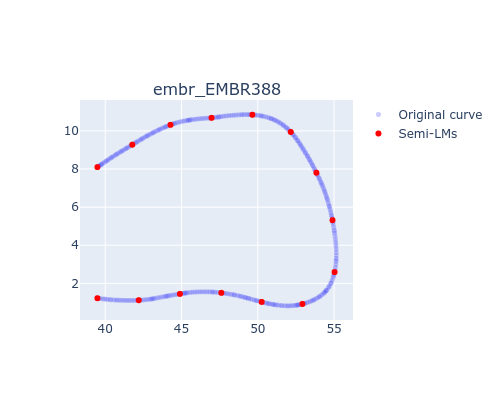

In [21]:
# extract the semi-LMs from the data frame
filter_col = [col for col in dfsl if col.startswith('semi-LM_')]
LMs = np.asarray(dfsl[filter_col])
LMs = LMs.reshape((len(specimen), Nr_SLM, dim))
LMs.shape

# plot an example
id = 18#18,60
check_file = f'{OUT_N_DIR}/check/{specimen[id]}.png'
curve = pv.read(f"{DATA_DIR}/{specimen[id]}.vtk")

sample = LMs[id,:,:]
print(sample.shape)

plot_landmarks([curve], [sample], (specimen[id],), pfile=None, show=True)

from IPython.display import Image
Image(check_file)